#### 住宅能耗参数敏感性分析

输入项：
- 外墙传热系数.
- 外窗传热系数.
- 外窗综合遮阳系数（SHGC）.
- 气密性.

输出项：
- 冷负荷.
- 热负荷.
- 总负荷（冷负荷+热负荷）.

### 数据读取与分析

In [2]:
# loading packages
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization and missing values
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
import missingno as msno # missing values
%matplotlib inline

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.ensemble import RandomForestRegressor
seed = 123

# importing data ( ? = missing values)
data = pd.read_csv("Auto-Data.csv", na_values = '?')
data.columns

C:\Users\HUAWEI\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


Index(['WALL(K)', 'WINDOWS(K)', 'SHGC', 'INFILTRATION', 'Cooling load',
       'Heeting load', 'Total load'],
      dtype='object')

In [3]:
data.dtypes

WALL(K)         float64
WINDOWS(K)      float64
SHGC            float64
INFILTRATION    float64
Cooling load    float64
Heeting load    float64
Total load      float64
dtype: object

In [4]:
# first glance at the data itself
print("In total: ",data.shape)
data.head(5)

In total:  (540, 7)


,WALL(K),WINDOWS(K),SHGC,INFILTRATION,Cooling load,Heeting load,Total load
0,0.3,2.5,0.1,0.5,48.765841,10.270088,59.035929
1,0.4,2.5,0.1,0.5,49.625221,10.894370,60.519591
2,0.5,2.5,0.1,0.5,50.401676,11.470901,61.872577
3,0.6,2.5,0.1,0.5,51.105525,12.006958,63.112483
4,0.7,2.5,0.1,0.5,51.755224,12.507259,64.262483


一个比较小的数据集:只有 205 条数据, 26个特征

In [5]:
data.describe()

,WALL(K),WINDOWS(K),SHGC,INFILTRATION,Cooling load,Heeting load,Total load
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,0.550000,2.000000,0.360000,1.166667,71.691300,12.339469,84.030768
std,0.170941,0.408627,0.162631,0.624188,11.232309,3.541563,11.816442
min,0.300000,1.500000,0.100000,0.500000,48.273831,5.449565,56.773407
25%,0.400000,1.500000,0.200000,0.500000,62.630342,9.542526,75.470956
50%,0.550000,2.000000,0.375000,1.000000,72.626328,11.671114,83.921960
75%,0.700000,2.500000,0.500000,2.000000,80.210446,15.422735,92.184595
max,0.800000,2.500000,0.600000,2.000000,93.258336,20.905843,110.415240


### 缺失值处理

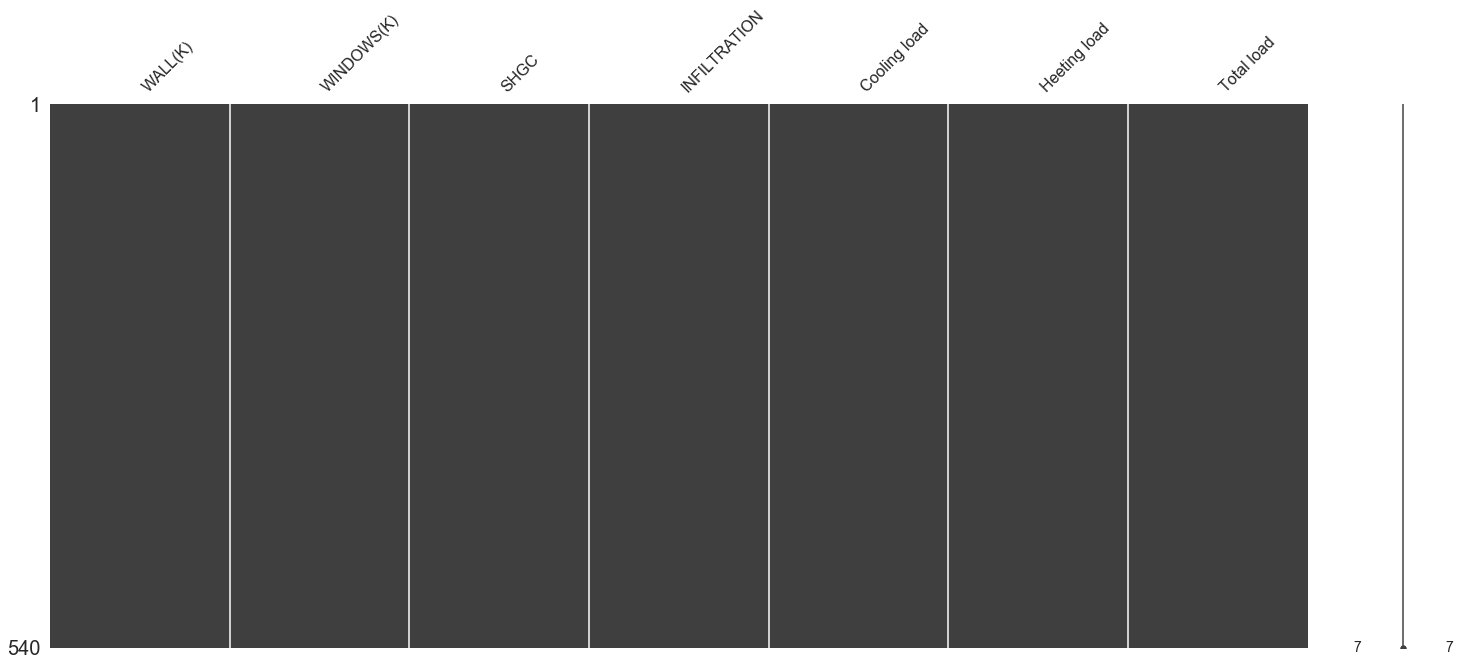

In [6]:
# missing values?
sns.set(style = "ticks")

msno.matrix(data)
#https://github.com/ResidentMario/missingno

In [8]:
data.groupby('INFILTRATION')['SHGC'].describe()

,count,mean,std,min,25%,50%,75%,max
INFILTRATION,,,,,,,,
0.5,180.0,0.36,0.162934,0.1,0.2,0.375,0.5,0.6
1.0,180.0,0.36,0.162934,0.1,0.2,0.375,0.5,0.6
2.0,180.0,0.36,0.162934,0.1,0.2,0.375,0.5,0.6


### 特征相关性

In [9]:
cormatrix = data.corr()
cormatrix

,WALL(K),WINDOWS(K),SHGC,INFILTRATION,Cooling load,Heeting load,Total load
WALL(K),1.000000e+00,0.000000e+00,-6.019972e-18,-5.743112e-17,0.050668,0.277946,0.131468
WINDOWS(K),0.000000e+00,1.000000e+00,-7.748723e-19,8.075684e-19,-0.005141,0.196953,0.054143
SHGC,-6.019972e-18,-7.748723e-19,1.000000e+00,4.423421e-16,0.945741,-0.294474,0.810731
INFILTRATION,-5.743112e-17,8.075684e-19,4.423421e-16,1.000000e+00,0.312441,0.891456,0.564178
Cooling load,5.066790e-02,-5.140901e-03,9.457409e-01,3.124407e-01,1.000000,0.011575,0.954035
Heeting load,2.779462e-01,1.969532e-01,-2.944741e-01,8.914562e-01,0.011575,1.000000,0.310717
Total load,1.314678e-01,5.414302e-02,8.107310e-01,5.641781e-01,0.954035,0.310717,1.000000


In [10]:
cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T  #返回函数的上三角矩阵，把对角线上的置0，让他们不是最高的。
cormatrix

,WALL(K),WINDOWS(K),SHGC,INFILTRATION,Cooling load,Heeting load,Total load
WALL(K),0.0,0.0,-6.019972e-18,-5.743112e-17,0.050668,0.277946,0.131468
WINDOWS(K),0.0,0.0,-7.748723e-19,8.075684e-19,-0.005141,0.196953,0.054143
SHGC,-0.0,-0.0,0.000000e+00,4.423421e-16,0.945741,-0.294474,0.810731
INFILTRATION,-0.0,0.0,0.000000e+00,0.000000e+00,0.312441,0.891456,0.564178
Cooling load,0.0,-0.0,0.000000e+00,0.000000e+00,0.000000,0.011575,0.954035
Heeting load,0.0,0.0,-0.000000e+00,0.000000e+00,0.000000,0.000000,0.310717
Total load,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000


In [11]:
cormatrix = cormatrix.stack()
cormatrix

WALL(K)       WALL(K)         0.000000e+00
              WINDOWS(K)      0.000000e+00
              SHGC           -6.019972e-18
              INFILTRATION   -5.743112e-17
              Cooling load    5.066790e-02
              Heeting load    2.779462e-01
              Total load      1.314678e-01
WINDOWS(K)    WALL(K)         0.000000e+00
              WINDOWS(K)      0.000000e+00
              SHGC           -7.748723e-19
              INFILTRATION    8.075684e-19
              Cooling load   -5.140901e-03
              Heeting load    1.969532e-01
              Total load      5.414302e-02
SHGC          WALL(K)        -0.000000e+00
              WINDOWS(K)     -0.000000e+00
              SHGC            0.000000e+00
              INFILTRATION    4.423421e-16
              Cooling load    9.457409e-01
              Heeting load   -2.944741e-01
              Total load      8.107310e-01
INFILTRATION  WALL(K)        -0.000000e+00
              WINDOWS(K)      0.000000e+00
           

In [12]:
cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
cormatrix.head(10)

WALL(K)     WALL(K)         0.000000e+00
            WINDOWS(K)      0.000000e+00
            SHGC           -6.019972e-18
            INFILTRATION   -5.743112e-17
            Cooling load    5.066790e-02
            Heeting load    2.779462e-01
            Total load      1.314678e-01
WINDOWS(K)  WALL(K)         0.000000e+00
            WINDOWS(K)      0.000000e+00
            SHGC           -7.748723e-19
dtype: float64

也可以直接画出来

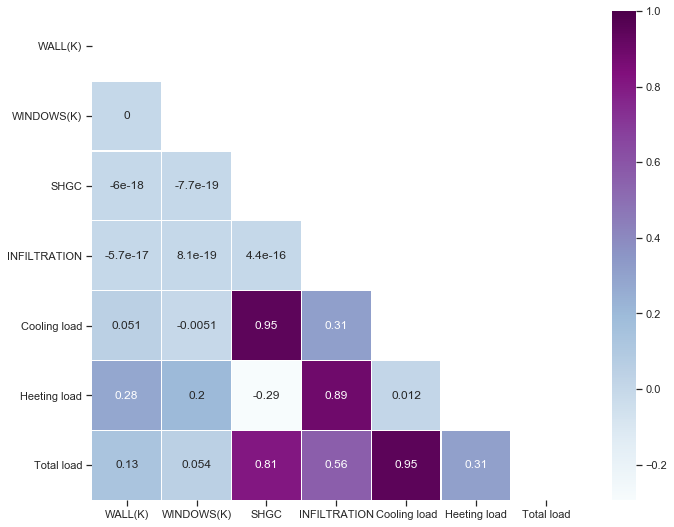

In [13]:
# Compute the correlation matrix 
corr_all = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5,annot=True, ax = ax, cmap = "BuPu")   
plt.show()

让我们仔细看看变量之间的关系

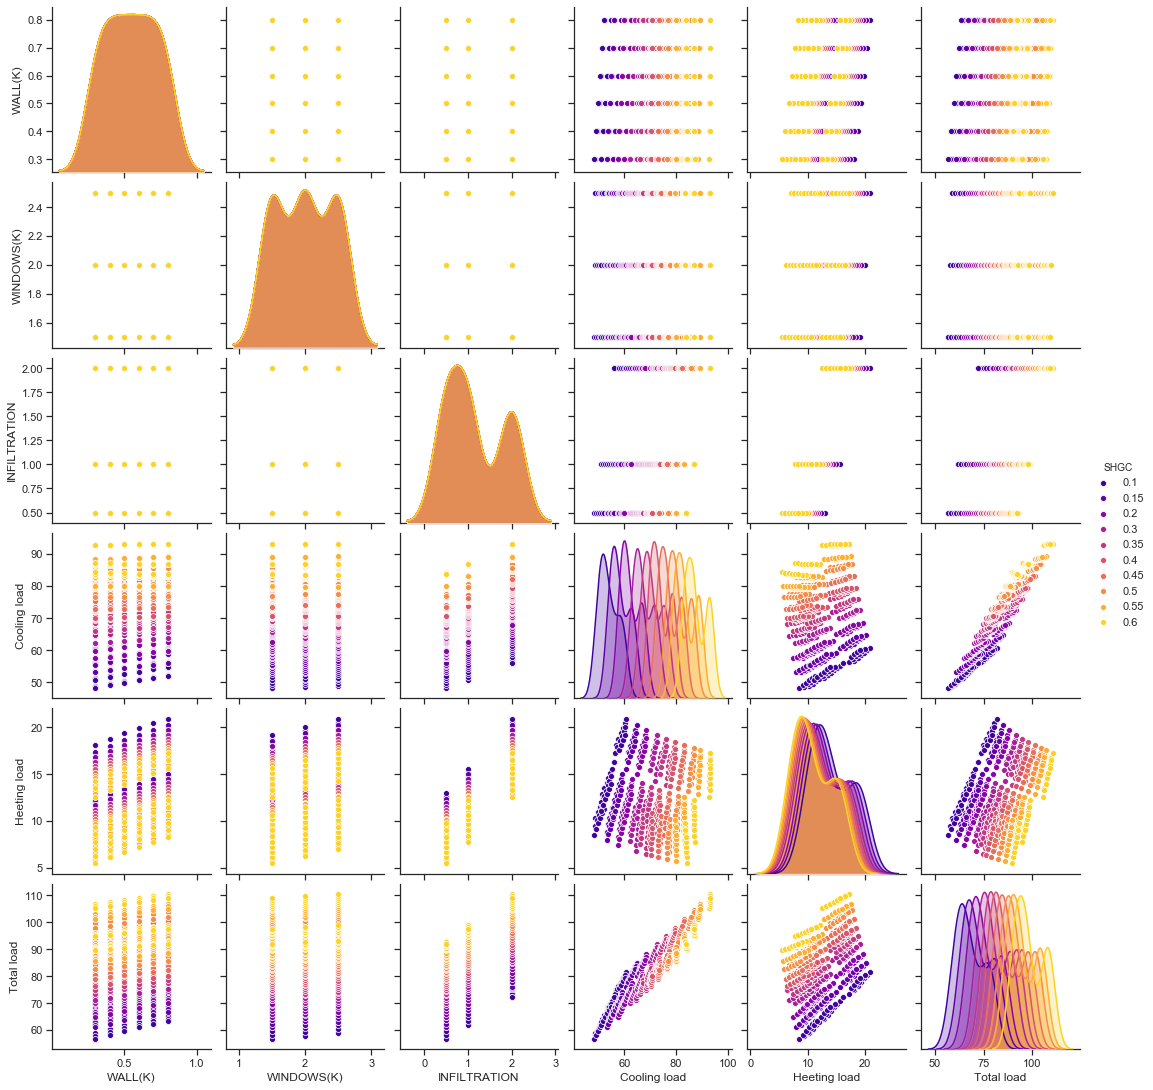

In [14]:
sns.pairplot(data, hue = 'SHGC', palette = 'plasma')

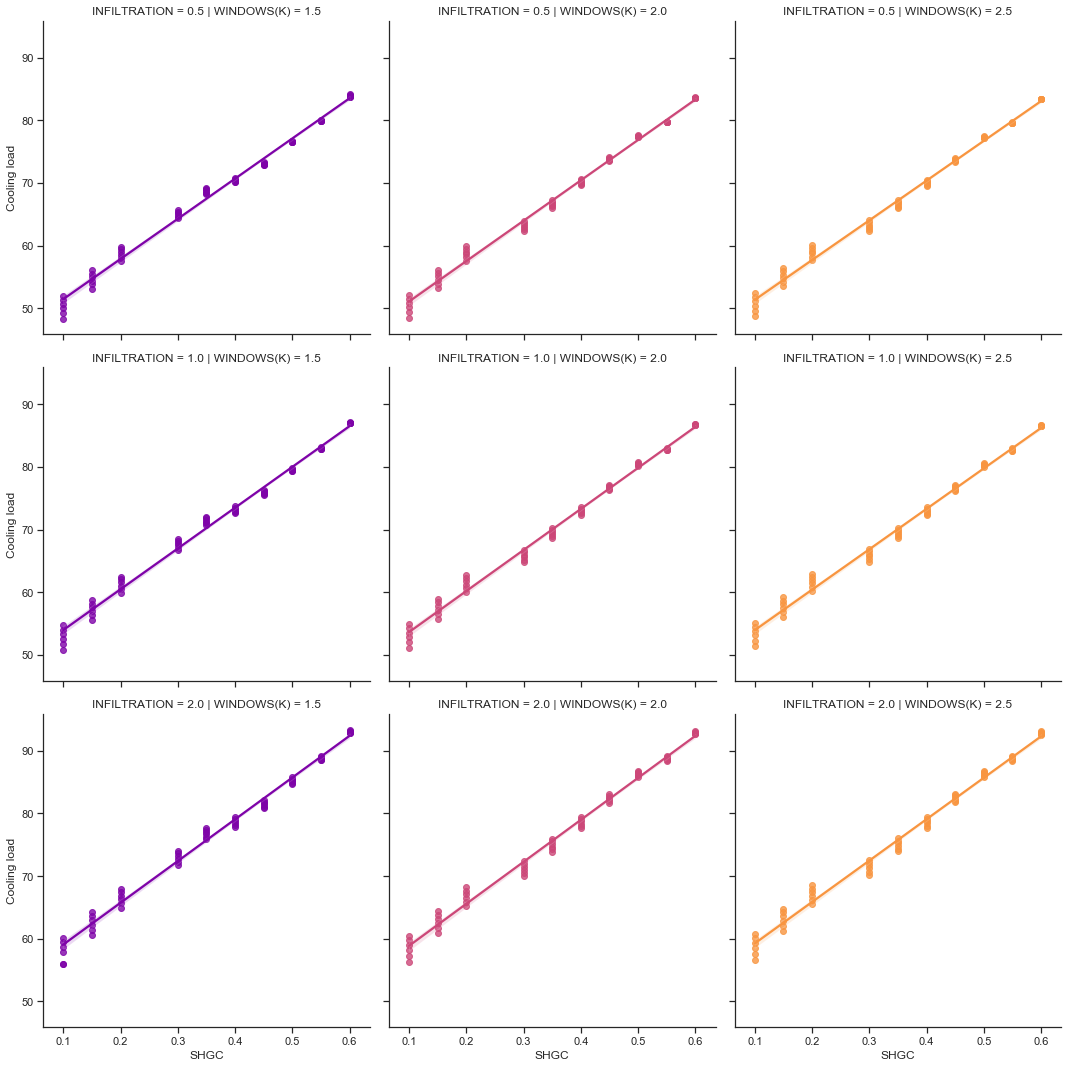

In [21]:
sns.lmplot( 'SHGC','Cooling load', data, 
           hue = 'WINDOWS(K)', col = 'WINDOWS(K)',  row = 'INFILTRATION', 
           palette = 'plasma', 
           fit_reg = True);

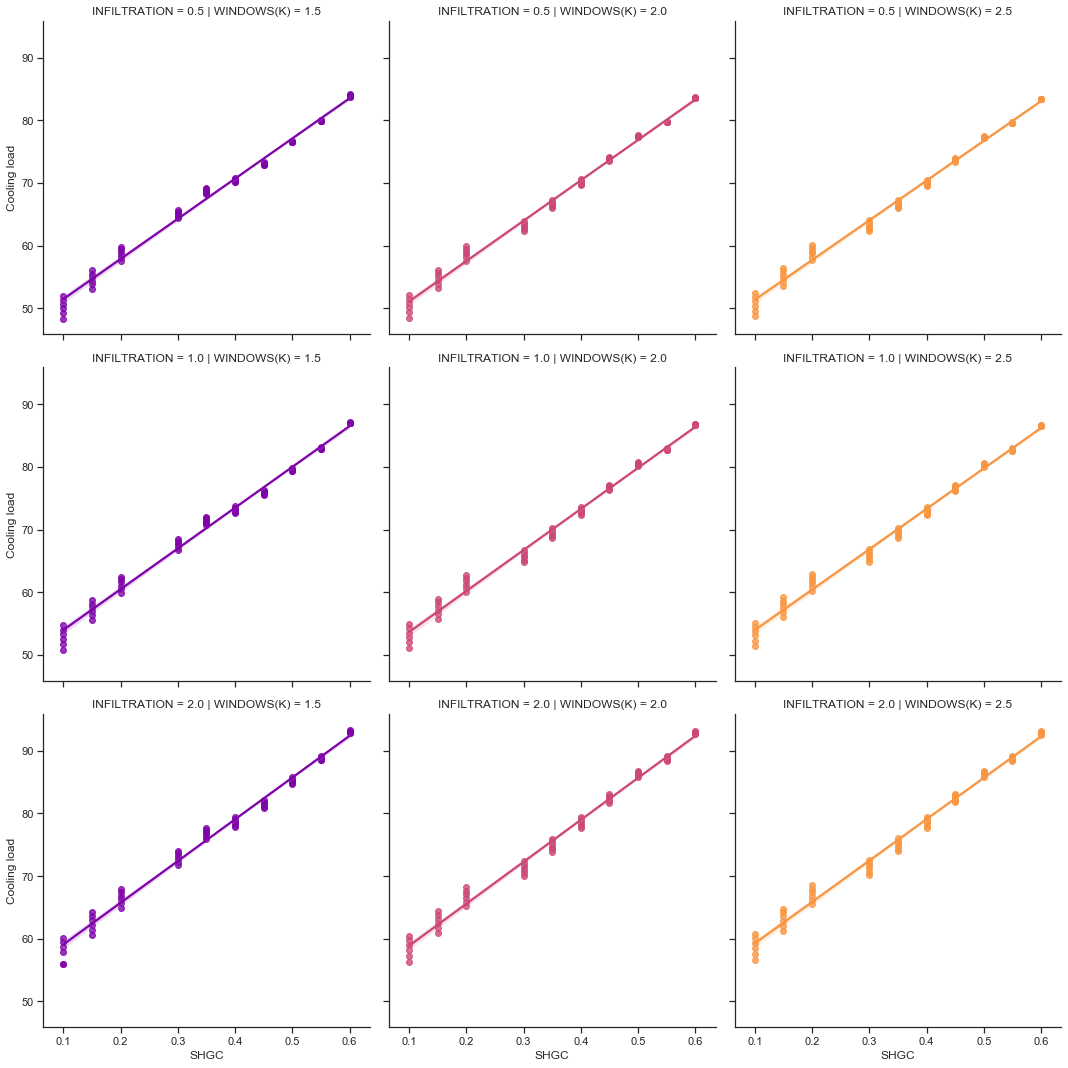

In [22]:
sns.lmplot( 'SHGC','Cooling load', data, 
           hue = 'WINDOWS(K)', col = 'WINDOWS(K)',  row = 'INFILTRATION', 
           palette = 'plasma', 
           fit_reg = True);

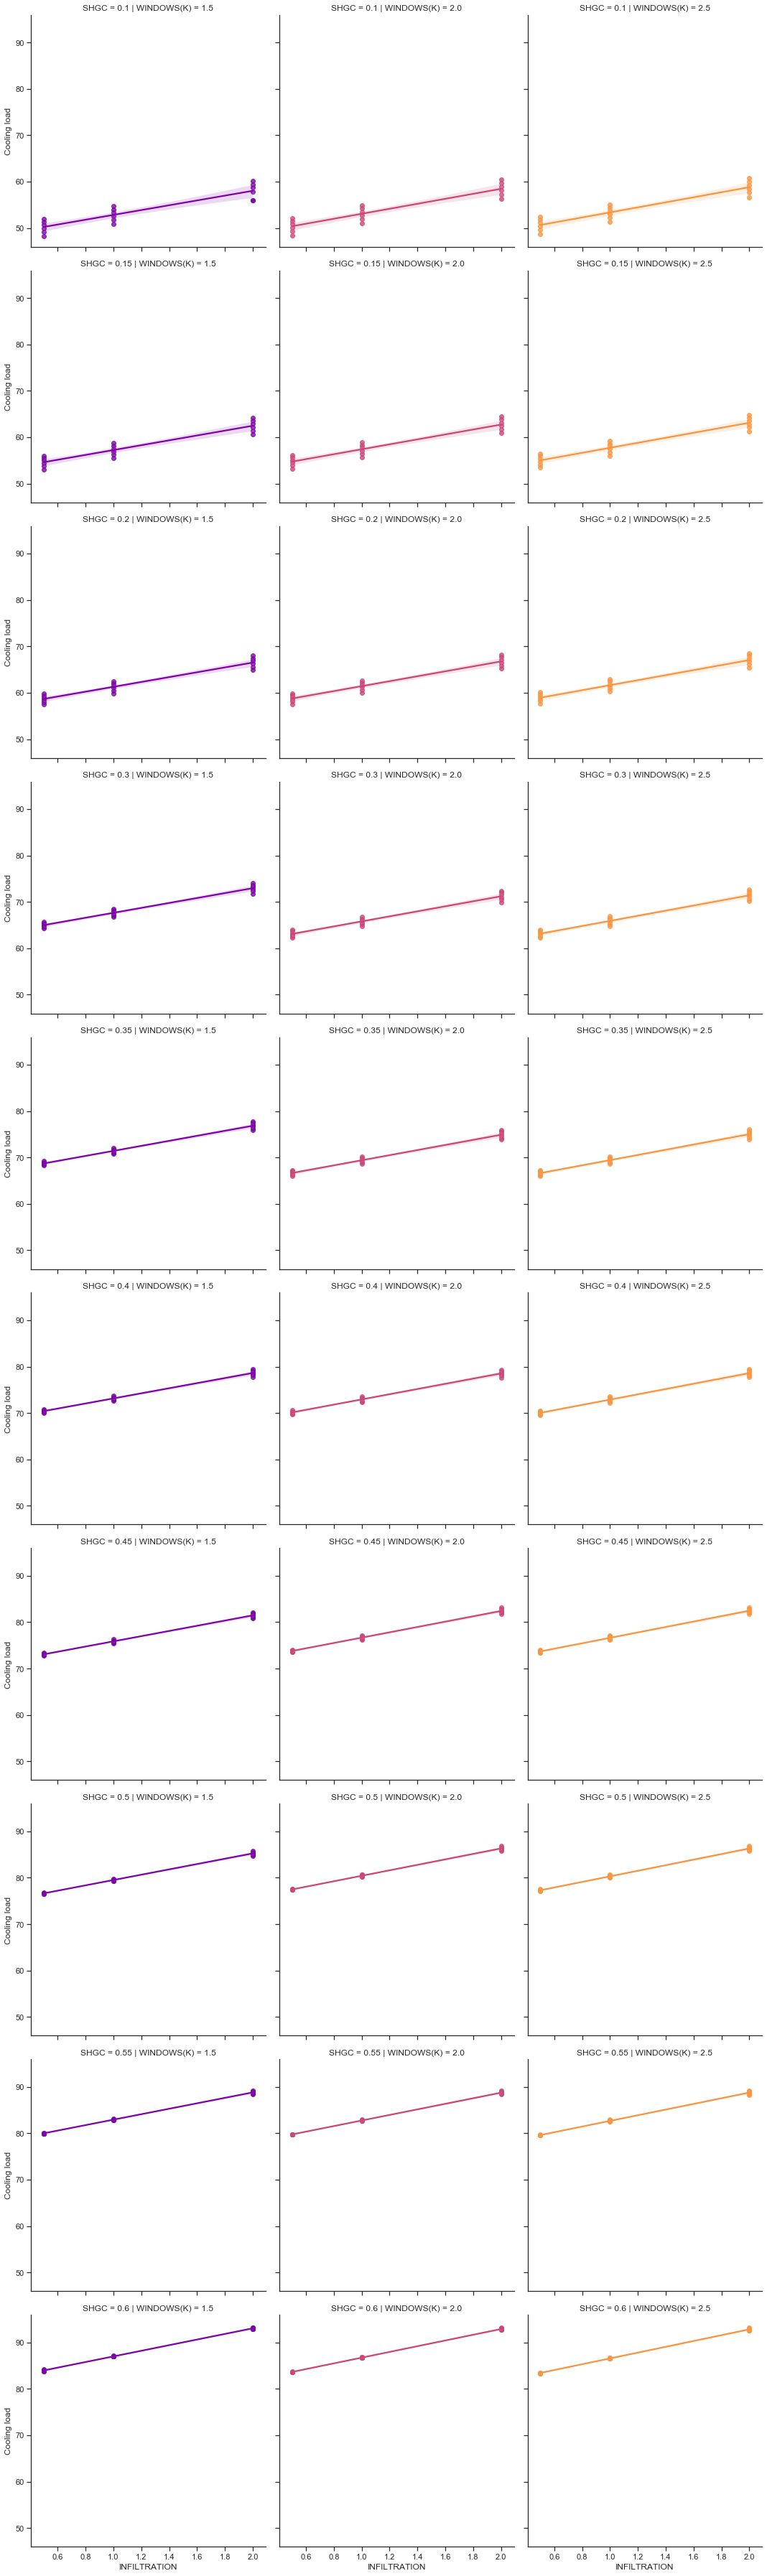

In [23]:
sns.lmplot( 'INFILTRATION','Cooling load', data, 
           hue = 'WINDOWS(K)', col = 'WINDOWS(K)',  row = 'SHGC', 
           palette = 'plasma', 
           fit_reg = True);

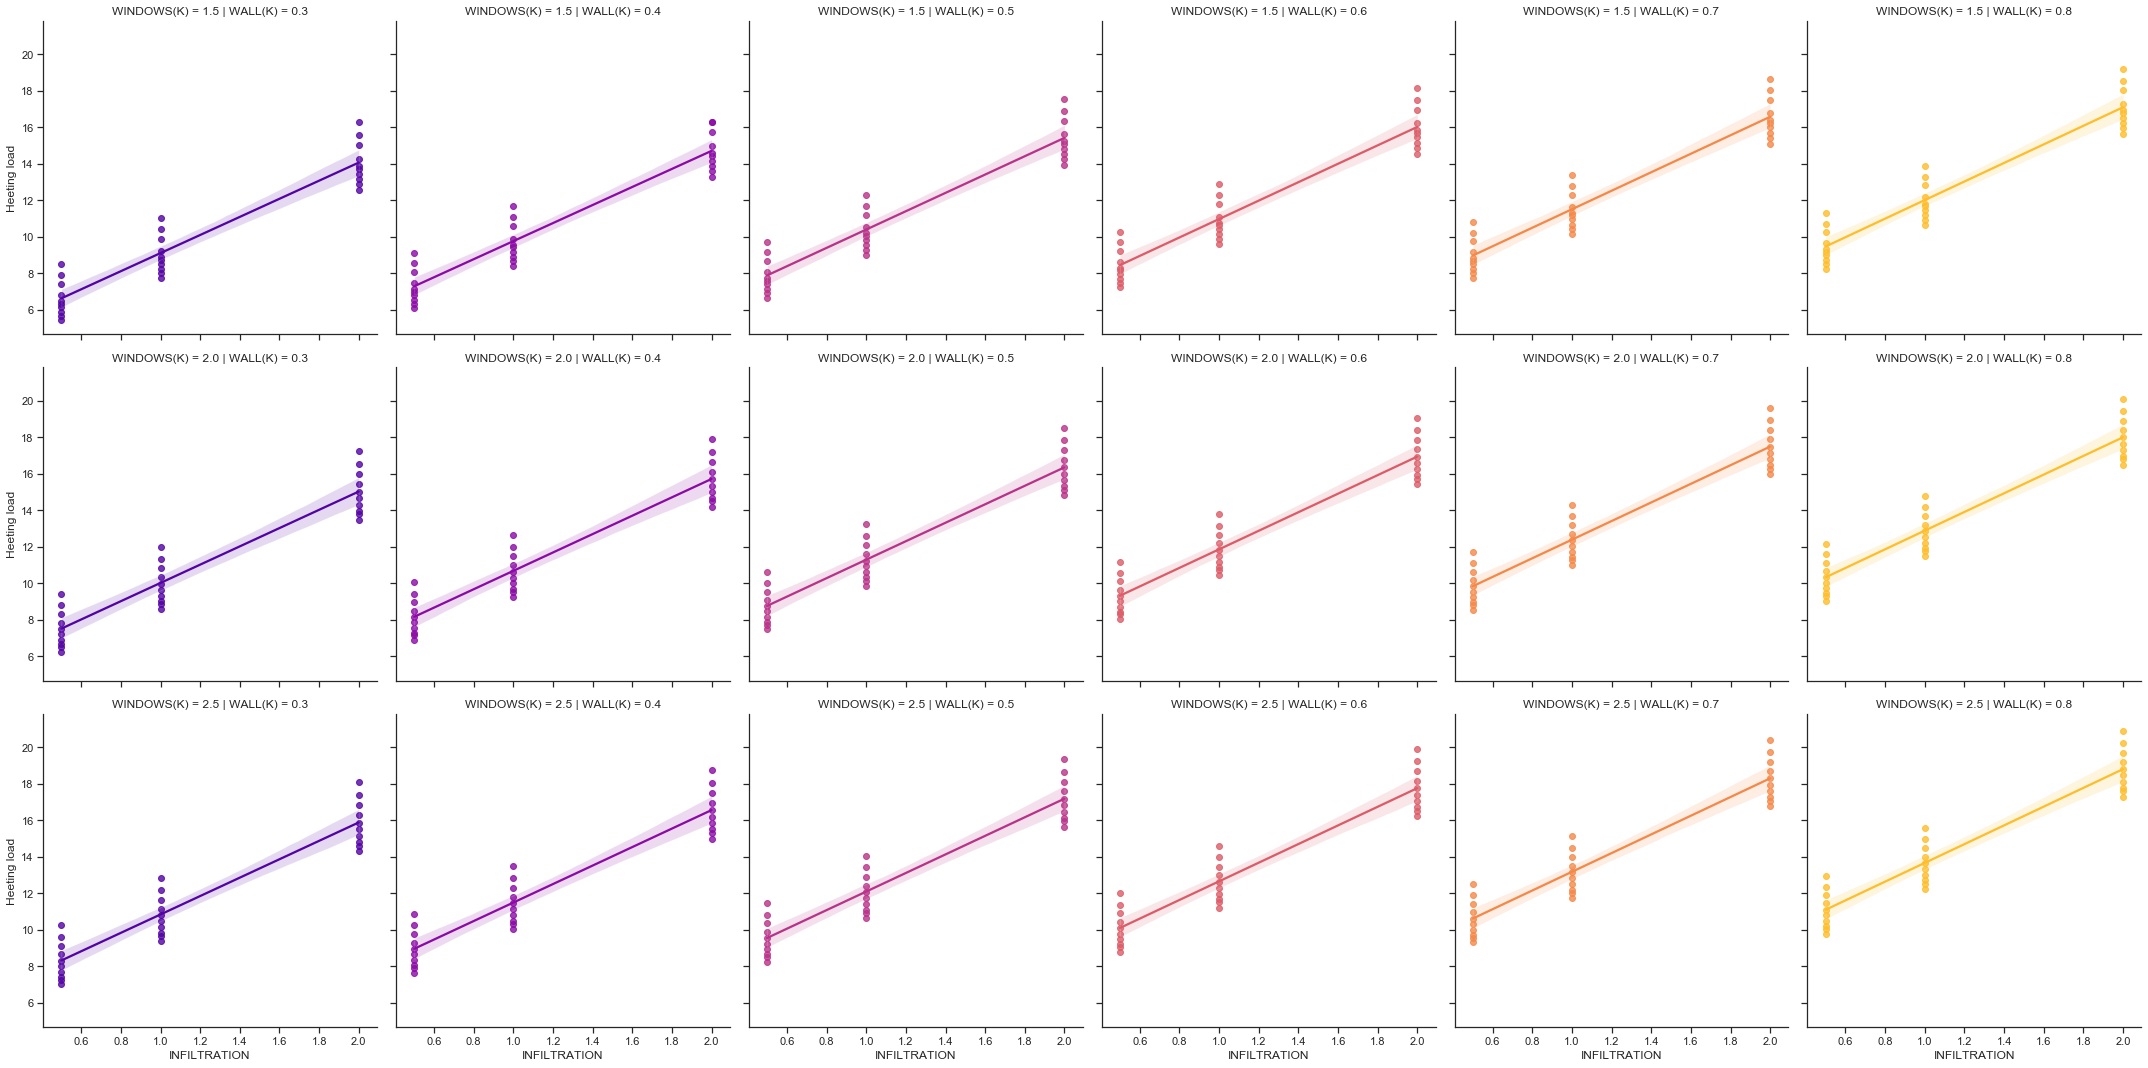

In [25]:
sns.lmplot( 'INFILTRATION', 'Heeting load',data, 
           hue = 'WALL(K)', col = 'WALL(K)',  row = 'WINDOWS(K)', 
           palette = 'plasma', 
           fit_reg = True);